In [1]:
pip install fastai fastcore --upgrade

     |████████████████████████████████| 188 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from fastai.imports import *
from fastai.vision.all import *


import os #for file management

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"


sns.set(style='white', context='notebook', palette='deep')


Mounted at /content/gdrive


In [3]:
pathTrain = Path(root_dir+'/base_dir/train_dir')
pathVal = Path(root_dir+'/base_dir/val_dir')

In [4]:

IMAGE_SIZE = 224
BATCH_SIZE = 30

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    pathTrain, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  
    batch_size = BATCH_SIZE, 
    subset='training' 
)
val_generator = datagen.flow_from_directory( 
    pathTrain, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    
    subset='validation'
)



Found 3197 images belonging to 7 classes.
Found 799 images belonging to 7 classes.


In [5]:
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys())) 
with open('labels.txt', 'w') as f: 
    f.write(labels)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [6]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, 
    weights='imagenet'
)
base_model.trainable=False

model = tf.keras.Sequential([ 
  base_model,
  tf.keras.layers.Conv2D(24,2, activation = 'relu'),      #Creates a convolutional kernel that will produce tensor of outputs. (Kernal size is 24 with a filter size of 2)
  tf.keras.layers.Dropout(0.2), 
  tf.keras.layers.Conv2D(12,2, activation = 'relu'),      #Convoluting kernel that will produce tensor of outputs. (Now we drop kernal size to 12 with a filter size of 2)
  tf.keras.layers.GlobalAveragePooling2D(),                 
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()


9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 24)          122904    
                                                                 
 dropout (Dropout)           (None, 6, 6, 24)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 12)          1164      
                                                                 
 global_average_pooling2d (G  (None, 12)               0         
 lobalAveragePooling2D)                                          
                                                           

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
epochs = 15 
history = model.fit(
    train_generator, 
    epochs = epochs, 
    validation_data= val_generator
)

Epoch 1/15
 13/107 [==>...........................] - ETA: 24:37 - loss: 2.0591 - accuracy: 0.2000

In [ ]:
saved_model_dir = '' 
tf.saved_model.save(model, saved_model_dir) 
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() 

with open('model.tflite', 'wb') as f: 
  f.write(tflite_model)

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: /tmp/tmpukm9mx7z/assets


INFO:tensorflow:Assets written to: /tmp/tmpukm9mx7z/assets


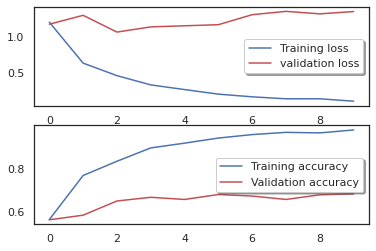

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:

n_batches = len(train_generator)
X_true = np.concatenate([np.argmax(train_generator[i][1], axis=1) for i in range(n_batches)])
X_pred_class = np.argmax(model.predict_generator(train_generator, steps=n_batches), axis=1)

n_batches = len(val_generator)
Y_true = np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(n_batches)])
Y_pred_class = np.argmax(model.predict_generator(val_generator, steps=n_batches), axis=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


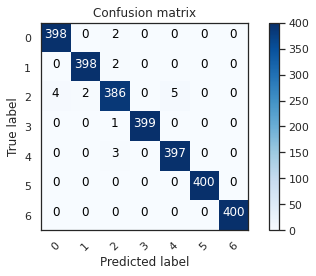

In [ ]:
confusion_mtx = confusion_matrix(X_true, X_pred_class) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

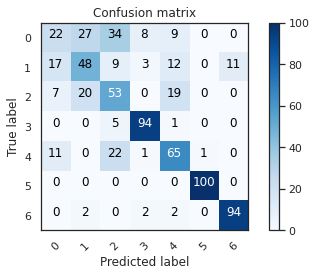

In [ ]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_class) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))